In [1]:
import seaborn as sns
import sdeint
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
import random
import numpy as np
import pycatch22 as catch22
from sympy import real_roots
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.optimize import fsolve
import scipy
import statistics
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA, FactorAnalysis
from scipy.spatial.distance import pdist, squareform, cdist

In [2]:
np.random.seed(42)

### Sampling from classes of dynamical behaviours

In [3]:
def sample_fixedpt(num_samples):
    samples_per_system = int(num_samples/3)

    # bistable
    eta_val_bistable = list()
    mu_val_bistable = list()
    n_val_bistable = list()
    lengths_store = list()
    sols_list = list()
    dt = 0.01
    count = 0
    while count < samples_per_system:
        eta = np.random.uniform(low=0, high=1)
        mu = np.random.uniform(low=-5, high=5)
        n = np.random.uniform(low=50, high=5000)

        length = ((n+500)*dt)
        tspan = np.arange(0, length, dt)
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        if (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            # switching, do not append
            continue
        else:
            count += 1
            sols_list.append(sol[500:])
            eta_val_bistable.append(eta)
            mu_val_bistable.append(mu)
            n_val_bistable.append(n)
            lengths_store.append(len(sol[500:])) # store length of time series after burn in

    ts_bistable = sols_list
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i][:,0])['values'] for i in range(len(sols_list))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['N'] = lengths_store
    df_bistable['mu'] = mu_val_bistable
    df_bistable['eta'] = eta_val_bistable
    df_bistable['regime'] = 'FixedPoint'
    df_bistable['system'] = 'Bistable'

    # hopf system

    eta_val_hopf = np.random.uniform(0, 1, samples_per_system)
    mu_val_hopf = np.random.uniform(-5, -0.01, samples_per_system)
    N_val_hopf = np.random.uniform(50, 5000, samples_per_system)
    lengths_store = list()
    sols_list = list()
    dt = 0.01
    for i in range(samples_per_system):
        length = ((N_val_hopf[i]+500)*dt)
        tspan = np.arange(0, length, dt)
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        lengths_store.append(len(sol[500:])) # store length of time series after burn in
        sols_list.append(sol[500:])

    features_hopf = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    ts_hopf = sols_list # return list of 2 dim. time series
    df_hopf = pd.DataFrame(features_hopf)
    df_hopf['N'] = lengths_store
    df_hopf['mu'] = mu_val_hopf
    df_hopf['eta'] = eta_val_hopf
    df_hopf['regime'] = 'FixedPoint'
    df_hopf['system'] = 'Hopf'

    # hooke's system

    n_val_hookes = np.random.uniform(low=50, high=5000, size=samples_per_system)
    eta_val_hookes = np.random.uniform(low=0, high=1, size=samples_per_system)
    mu_val_hookes = np.random.uniform(low=-5, high=-0.01, size=samples_per_system)
    sols_list = list()
    lengths_store = list()
    dt = 0.01
    for i in range(samples_per_system):
        length = ((n_val_hookes[i]+500)*dt)
        tspan = np.arange(0, length, dt)
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform(low=0, high=0.2)])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        lengths_store.append(len(sol[500:])) # store length of time series after burn in
        sols_list.append(sol[500:])
    features_hookes = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    ts_hookes = sols_list
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['N'] = lengths_store
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['regime'] = 'FixedPoint'
    df_hookes['system'] = 'Hookes'

    ts = ts_bistable + ts_hopf + ts_hookes
    df = pd.concat([df_bistable, df_hopf, df_hookes], ignore_index=True)


    return ts, df


In [4]:
ts1, df1 = sample_fixedpt(5000)

In [4]:
def sample_limitCycle(num_samples):

    # hopf system
    eta_val_hopf = np.random.uniform(0, 1, num_samples)
    mu_val_hopf = np.random.uniform(0, 5, num_samples)
    N_val_hopf = np.random.uniform(50, 5000, num_samples)
    lengths_store = list()
    sols_list = list()
    dt = 0.01
    for i in range(num_samples):
        length = ((N_val_hopf[i]+500)*dt)
        tspan = np.arange(0, length, dt)
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        lengths_store.append(len(sol[500:])) # store length of time series after burn in
        sols_list.append(sol[500:])

        
    features_hopf = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    ts_hopf = sols_list # return list of 2 dim. time series
    df_hopf = pd.DataFrame(features_hopf)
    df_hopf['N'] = lengths_store
    df_hopf['mu'] = mu_val_hopf
    df_hopf['eta'] = eta_val_hopf
    df_hopf['regime'] = 'LimitCycle'
    df_hopf['system'] = 'Hopf'

    return ts_hopf, df_hopf
    

In [5]:
#import plotly.graph_objs as go
#trace = go.Scatter(x=pca[:,0], y=pca[:,1],mode ='markers', marker = dict(color = df2['eta']), text = df2.index)
#layout = go.Layout(title='Interactive Scatter Plot', hovermode ='closest', width=1000, height=800)
#fig = go.Figure(data = [trace], layout = layout)
#fig.show()

In [5]:
ts2, df2 = sample_limitCycle(5000)

KeyboardInterrupt: 

In [327]:
# remove NaNs
#df2 = df2.dropna()

In [8]:
def sample_switching(num_samples):
    eta_val_bistable = list()
    mu_val_bistable = list()
    sols_list = list()
    lengths_store = list()
    dt = 0.01
    count = 0 
    while count < num_samples:
        mu = np.random.uniform(low=-0.38487849, high=0.38487849)
        eta = np.random.uniform(0.001, 1)
        n = np.random.uniform(50, 5000)
        length = ((n+500)*dt)
        tspan = np.arange(0, length, dt)
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check for switching condition
        if (max_actual >= max_root) & (min_actual <= min_root):
            eta_val_bistable.append(eta)
            mu_val_bistable.append(mu)
            sols_list.append(sol[500:])
            lengths_store.append(len(sol[500:])) # store length of time series after burn in
            count += 1
    ts_bistable = sols_list 
    features_bistable = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features_bistable)
    df['N'] = lengths_store
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    df['regime'] = 'Switching'
    df['system'] = 'Bistable'
    
    return ts_bistable, df


In [9]:
ts3, df3 = sample_switching(5000)

In [17]:
all_instances = pd.concat([df1, df2, df3], ignore_index=True)
all_ts = ts1 + ts2 + ts3

In [11]:
all_instances.shape

(14998, 27)

In [483]:
#import scipy.special

#def MixedSig(X):
#    X = X.to_numpy()
#    iqrX = scipy.stats.iqr(X, axis=0)
#    Xhat = X
#    for index, iqr in enumerate(iqrX):
#        if iqr == 0:
#            meanX = np.mean(X[:,index])
#            stdX = np.std(X[:, index])
#            Xhat[:,index] = scipy.special.expit((X[:, index] - meanX)/stdX) # expit() is more stable for small and large values
#        else:
#            medianX = np.median(X[:, index])
#            Xhat[:, index] = scipy.special.expit((X[:, index] - medianX)/(1.1*iqrX[index]))
#    minX = np.min(Xhat, axis=0)
#    maxX = np.max(Xhat, axis=0)
#    Xhat = (Xhat - minX)/(maxX - minX)
#    return Xhat


In [443]:
#MixedSigmoid = FunctionTransformer(MixedSig)

In [444]:
#sig_fit = MixedSigmoid.fit(all_instances.iloc[:,:22])
#Xhat = sig_fit.transform(all_instances.iloc[:,:22])

-------------------------

In [38]:
rs = RobustScaler().fit(all_instances.iloc[:,:22])
rs_transformed = rs.transform(all_instances.iloc[:,:22])
def sigmoid(X):
    return 1/(1+scipy.special.expit(-X))
sig_transformed = sigmoid(rs_transformed)
mm = MinMaxScaler().fit(sig_transformed)
mm_transformed = mm.transform(sig_transformed)
Xhat = mm_transformed

In [39]:
pca_fit = PCA(n_components=2).fit(Xhat)
pca = pca_fit.transform(Xhat)

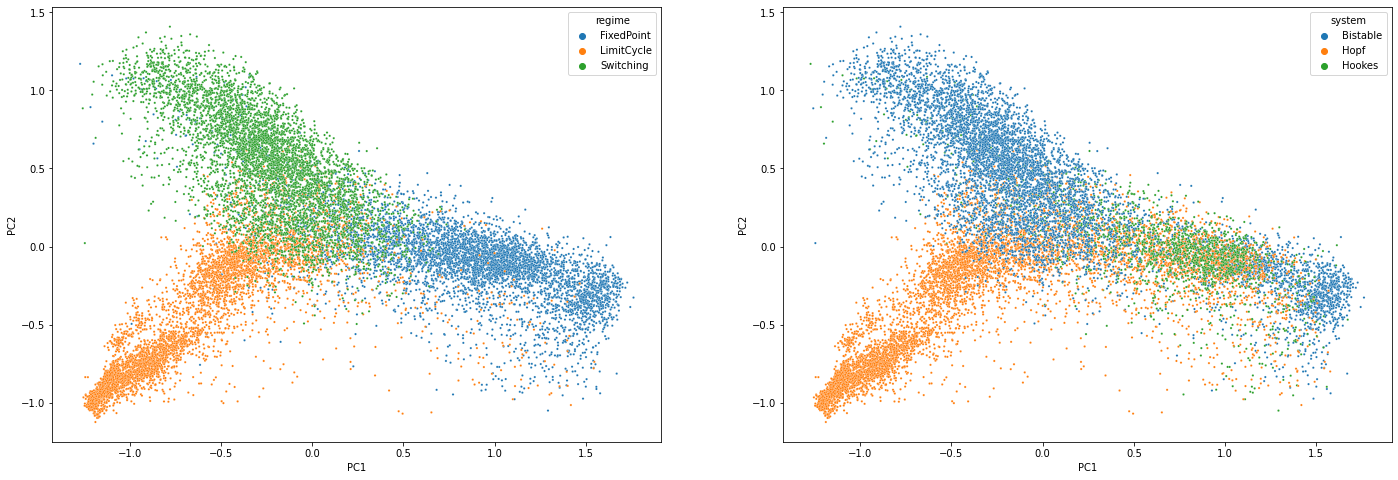

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=all_instances['regime'],ax=ax[0], s=5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')

sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=all_instances['system'], ax=ax[1], s=5)
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
plt.show()

Thesis figure generation

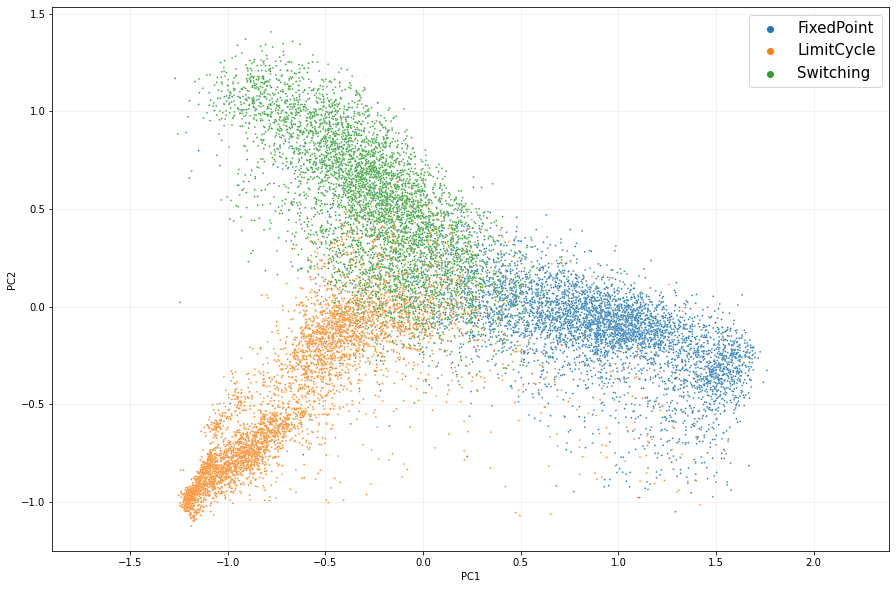

In [56]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=all_instances['regime'], s=3)
plt.legend(fontsize=15)
plt.grid(alpha=0.2)
plt.axis('equal')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

instance similarity distributions -> look at the distribution of the similarity of the instances in the same class versus other classes using a distance metric to determine similarity

In [481]:
import plotly.express as px
import numpy as np
df = px.data.iris()
fig = px.scatter(x=pca[:,0], y=pca[:,1], color=all_instances['regime'],
                 hover_data={'Regime': all_instances['regime'],
                            'System:': all_instances['system'],
                            'eta:' : all_instances['eta'],
                            'mu:' : all_instances['mu'],
                            'N:' : all_instances['N'],
                            'idx:' : all_instances.index
                            })
fig.update_layout(height=800, width=1200)
fig.show()

In [22]:
ts_val_lc, df_val_lc = sample_limitCycle(500)
ts_val_fp, df_val_fp = sample_fixedpt(500)
ts_val_sw, df_val_sw = sample_switching(500)
val_data = pd.concat([df_val_lc, df_val_fp, df_val_sw], ignore_index=True)

In [23]:
encodings = {'LimitCycle': 0, 'FixedPoint': 1, 'Switching': 2}
val_data_labels = np.array(val_data['regime'].map(encodings))

In [24]:
train_data_labels = np.array(all_instances['regime'].map(encodings))

In [25]:
val_data_embeddings = pca_fit.transform(mm.transform(sigmoid(rs.transform((val_data.iloc[:,:22])))))

In [26]:
accuracies = list()
epsilons = np.linspace(0.05, 2, 100)
for epsilon in epsilons:
    predictions = list()
    for instance in val_data_embeddings:
        x, y = instance
        neighbours_idx = np.argwhere(((pca[:,0] - x)**2 + (pca[:,1] - y)**2) < (epsilon**2))
        if len(neighbours_idx) == 0:
            # set to nearest pt
            neighbours_idx = np.argmin(((pca[:,0] - x)**2 + (pca[:,1] - y)**2))
        neighbours = train_data_labels[neighbours_idx]
        unique, counts = np.unique(neighbours, return_counts=True)
        pred = unique[np.argmax(counts)]
        predictions.append(pred)
    matches = np.count_nonzero(predictions == val_data_labels)
    accuracy = matches/len(val_data_embeddings)
    accuracies.append(accuracy)

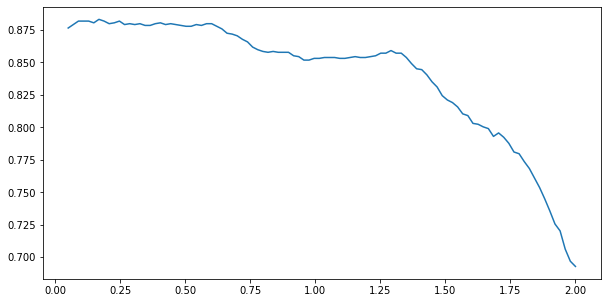

In [27]:
plt.figure(figsize=(10,5))
plt.plot(epsilons, accuracies)
plt.show()

Start with short time series data (N=100), generate epsilon curve across 5 folds

5 Fold

In [32]:
num_folds = 5
epsilons = np.linspace(0.05, 2, 100)
encodings = {'LimitCycle': 0, 'FixedPoint': 1, 'Switching': 2}
meta_acc = list()
for fold in range(num_folds):

    # generate training data
    ts_train_lc, df_train_lc = sample_limitCycle(200)
    ts_train_fp, df_train_fp = sample_fixedpt(200)
    ts_train_sw, df_train_sw = sample_switching(200)
    train_data = pd.concat([df_train_lc, df_train_fp, df_train_sw], ignore_index=True)
    train_data_labels = np.array(train_data['regime'].map(encodings))

    # fit PCA
    rs = RobustScaler().fit(train_data.iloc[:,:22])
    rs_transformed = rs.transform(train_data.iloc[:,:22])
    def sigmoid(X):
        return 1/(1+scipy.special.expit(-X))
    sig_transformed = sigmoid(rs_transformed)
    mm = MinMaxScaler().fit(sig_transformed)
    mm_transformed = mm.transform(sig_transformed)
    Xhat = mm_transformed
    pca_fit = PCA(n_components=2).fit(Xhat)
    pca = pca_fit.transform(Xhat)



    # generate validation data
    ts_val_lc, df_val_lc = sample_limitCycle(50)
    ts_val_fp, df_val_fp = sample_fixedpt(50)
    ts_val_sw, df_val_sw = sample_switching(50)
    val_data = pd.concat([df_val_lc, df_val_fp, df_val_sw], ignore_index=True)
    val_data_labels = np.array(val_data['regime'].map(encodings))

    val_data_embeddings = pca_fit.transform(mm.transform(sigmoid(rs.transform((val_data.iloc[:,:22])))))
    
    accuracies = list()
    for epsilon in epsilons:
        predictions = list()
        for instance in val_data_embeddings:
            x, y = instance
            neighbours_idx = np.argwhere(((pca[:,0] - x)**2 + (pca[:,1] - y)**2) < (epsilon**2))
            if len(neighbours_idx) == 0:
                # set to nearest pt
                neighbours_idx = np.argmin(((pca[:,0] - x)**2 + (pca[:,1] - y)**2))
            neighbours = train_data_labels[neighbours_idx]
            unique, counts = np.unique(neighbours, return_counts=True)
            pred = unique[np.argmax(counts)]
            predictions.append(pred)
        matches = np.count_nonzero(predictions == val_data_labels)  
        accuracy = matches/len(val_data_embeddings)
        accuracies.append(accuracy)

    meta_acc.append(accuracies)


In [33]:
meta_acc = np.array(meta_acc)

In [34]:
mean_acc = np.mean(meta_acc, axis=0)
std_acc = np.std(meta_acc, axis=0)

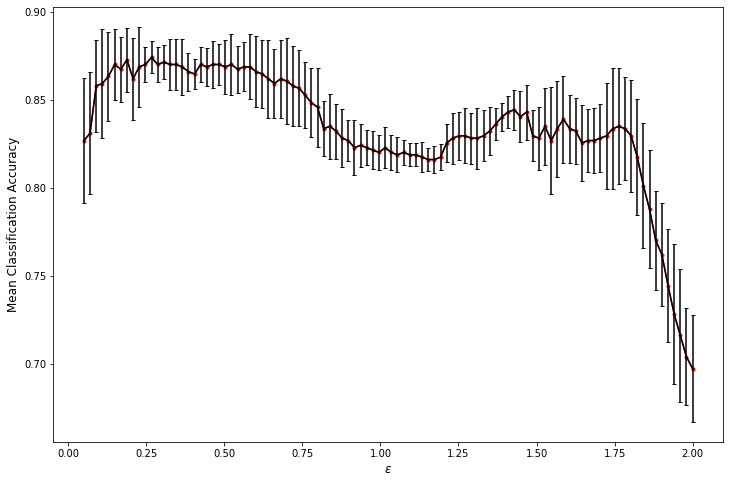

In [35]:
plt.figure(figsize=(12,8))
plt.plot(epsilons, mean_acc, '.-', c='r')
plt.errorbar(epsilons, mean_acc, yerr=std_acc, capsize=2, c='k')
plt.xlabel(r'$\epsilon$', fontsize=12)
plt.ylabel('Mean Classification Accuracy', fontsize=12)
plt.show()